In [22]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def decompose(signal, signals):
    # assumes signals are orthonormalized
    return torch.tensor([torch.tensor(signal).dot(torch.tensor(h)) for h in signals])

In [24]:
df = pd.read_csv('data/zinc_test_rec.csv', index_col=1)
df.sort_index(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [25]:
def lapFromInfo(edge_index, num_nodes):
    laplacian = torch.zeros((num_nodes, num_nodes), dtype=torch.float64)
    for i,j in zip(*edge_index):
        laplacian[i, j] = -1
        laplacian[j, i] = -1
        laplacian[i, i] += 1
        laplacian[j, j] += 1
    return laplacian

In [ ]:
def plotDecomp(edge_index, num_nodes, signals, ax, idx):
    
    # get graph spectrum info
    laplacian = lapFromInfo(edge_index, num_nodes)
    eigvals, eigvecs = torch.eig(laplacian, eigenvectors=True)
    eigvals = eigvals[:, 0]  # take the real part of eigenvalues
    sorted_indices = torch.argsort(eigvals)
    eigvecs_sorted = eigvecs[:, sorted_indices]
    eigvals_sorted = eigvals[sorted_indices]
    eigvec_list = [eigvecs_sorted[:, i] for i in range(eigvecs_sorted.shape[1])]
    
    # get decompositions
    decompositions = [torch.abs(decompose(eigvec, signals)) for eigvec in eigvec_list]
    
    # plot the decompositions as an image
    decompositions_plot = torch.stack(decompositions).detach().numpy().T
    ax.axis('on')
    im = ax.imshow(decompositions_plot, aspect='auto', cmap='viridis')
    ax.invert_yaxis()
    ax.set_xlabel('Eigenvector Index')
    ax.set_ylabel('Harmonic Index')
    ax.set_title(f'graph {idx} (n={num_nodes})')

    # add a line at y=num_nodes
    ax.axhline(y=num_nodes-0.5, color='r', linestyle='--')

In [27]:
def normalize_vectors(vectors):
    normed = []
    for v in torch.tensor(vectors, dtype=torch.float64):
        normed.append(v / torch.norm(v))
    return torch.stack(normed)

In [28]:
def batch_sort(items, keys):
    # Sort the dyadic-power-delimited chunks
    sorted_items = [item for item in items]
    i = 1
    while i < 2*len(keys):
        sorted_indices = sorted(list(range(i//2, i)), key=lambda x: keys[x])
        sorted_items[i//2:i] = [sorted_items[idx] for idx in sorted_indices]
        i *= 2
    return sorted_items

In [29]:
def energies(vecs, lap): # vectors should be row-wise in a tensor
    return [x.item() for x in torch.diag(vecs @ lap @ vecs.T)]

/home/bsw38/.conda/envs/benchmark_gnn_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


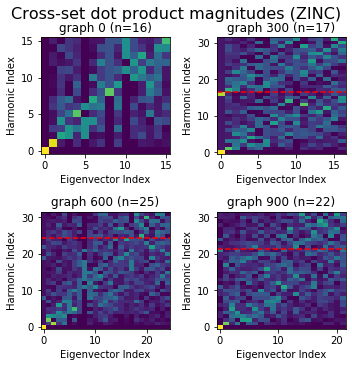

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs_list = axs.flatten()
for ax in axs_list:
    ax.axis('off')
fig.suptitle('Cross-set dot product magnitudes (ZINC)', fontsize=16, y=1.01)
for j,i in enumerate(list(range(0, df.shape[0], 300))):
    signals = eval(df.signals[i])
    num_nodes = df.num_nodes[i]
    edge_index = eval(df.edge_index[i])
    
    signals = normalize_vectors(signals) 
    laplacian = lapFromInfo(edge_index, num_nodes)
    energ = energies(signals, laplacian)
    signals = batch_sort(signals, energ)
    plotDecomp(edge_index, num_nodes, signals, axs_list[j], i)
    
plt.tight_layout()
plt.show()